### <center>Object Detection</center>

Comparison of the results of two pre-trained models:

*  __[Inception Resnet V2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1)__ - high quality object detection module; 
*  __[MobileNet V2](https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1)__ - small and fast object detection module.


The functions from __[TensorFlow](https://www.tensorflow.org/)__ docs have been simplified and modified to work with images from a local directory.

In [1]:
import os, time

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
import functools

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import IPython.display as display

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print(tf.__version__)

2.1.0


#### Basic functions 

In [2]:
base_dir = 'images/'
image_set = []

for f in os.listdir(base_dir):    
    image_set.append(base_dir+f)
    
image_set

['images/animals.jpg',
 'images/cat.jpg',
 'images/city.jpg',
 'images/girls.jpg',
 'images/people.jpg',
 'images/pet.jpg']

In [9]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=3,
                               display_str_list=()):

    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)], width=thickness, fill=color)
    
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    # Text box
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin

In [20]:
# min_score' parameter of function 'draw_boxes' sets minimum accuracy 
# at which the objects are displayed. This parameter will be determined 
# by the separate variable.
def draw_boxes(image, 
               boxes, 
               class_names, 
               scores, 
               max_boxes=10):
    
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

#### Load pre-trained models from __[TensorFlow Hub](https://tfhub.dev/s?module-type=image-object-detection&tf-version=tf1)__.

**Inception Resnet V2**:

In [4]:
%%time
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Wall time: 1min 11s


**MobileNet V2**:

In [5]:
%%time
module_handle_1 = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" 

detector_1 = hub.load(module_handle_1).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Wall time: 15.7 s


In [19]:
def run_detector(detector, path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    # Execution time
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Execution time: {:.2f} s".format(round((end_time-start_time), 3)))

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])
    
    plt.imshow(image_with_boxes)

**Object Detection**

#### 1.

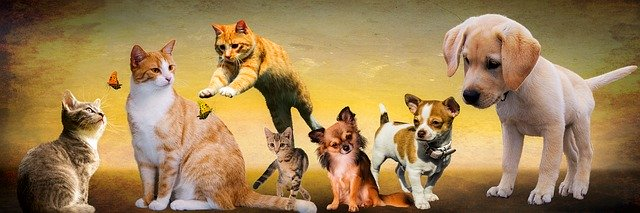

In [7]:
Image.open(image_set[0])

Execution time: 13.54 s


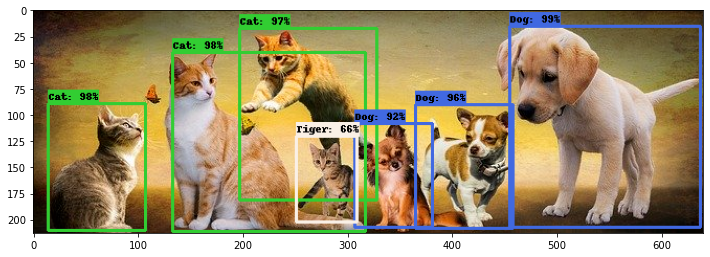

In [21]:
# Inception Resnet V2
min_score = .3
run_detector(detector, image_set[0])

Execution time: 5.17 s


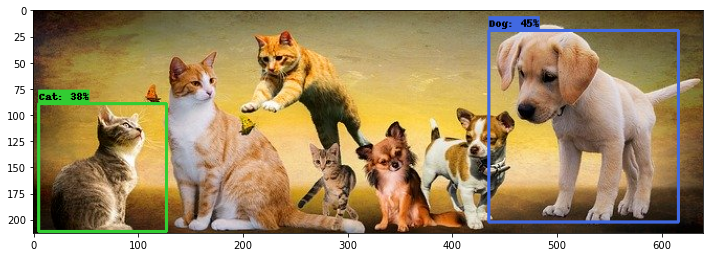

In [13]:
# MobileNet V2
run_detector(detector_1, image_set[0])

#### 2.

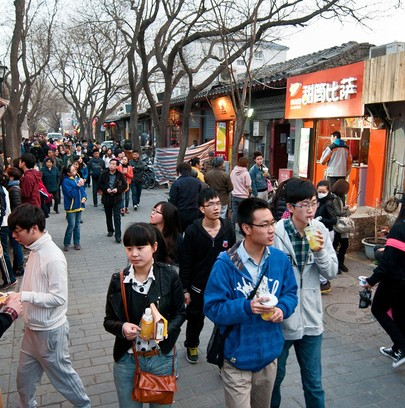

In [14]:
Image.open(image_set[2])

Execution time: 13.65 s


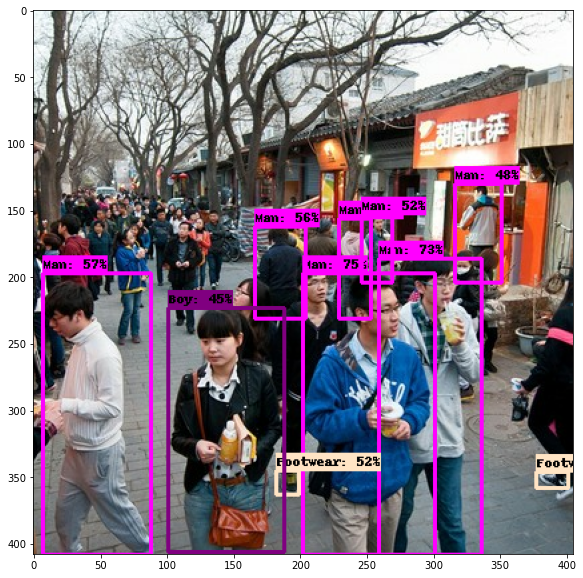

In [22]:
# Inception Resnet V2
run_detector(detector, image_set[2])

Execution time: 0.11 s


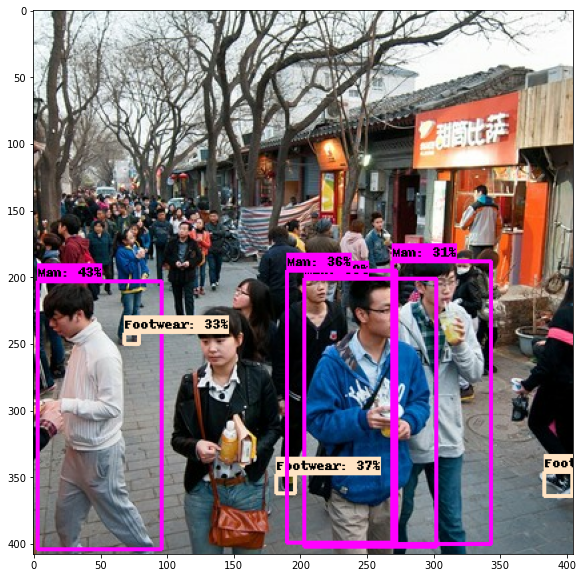

In [23]:
# MobileNet V2
run_detector(detector_1, image_set[2])

#### 3.

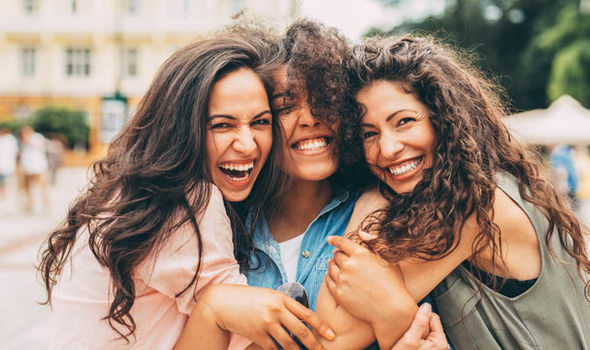

In [24]:
Image.open(image_set[3])

Execution time: 16.21 s


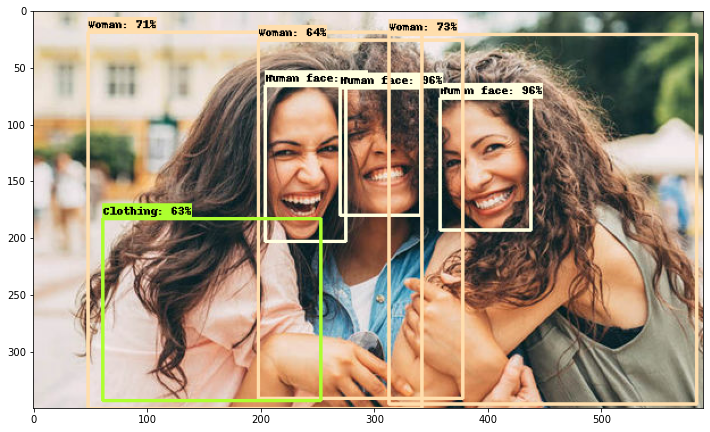

In [25]:
# Inception Resnet V2
min_score = .6
run_detector(detector, image_set[3])

Execution time: 0.12 s


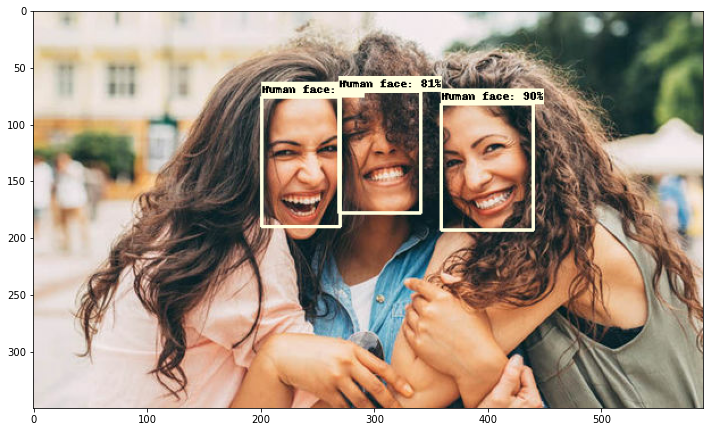

In [26]:
# MobileNet V2
run_detector(detector_1, image_set[3])

#### 4.

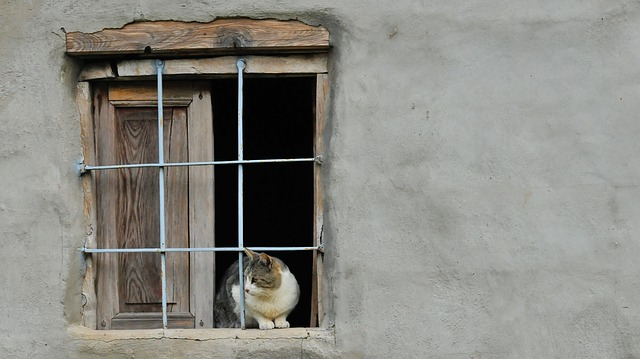

In [27]:
Image.open(image_set[5])

Execution time: 15.81 s


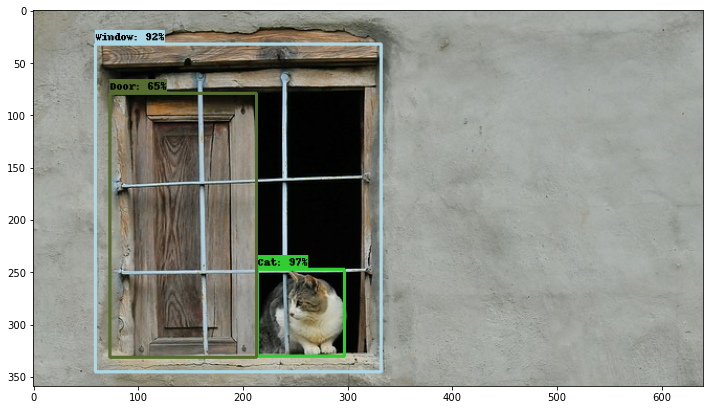

In [28]:
# Inception Resnet V2
run_detector(detector, image_set[5])

Execution time: 0.12 s


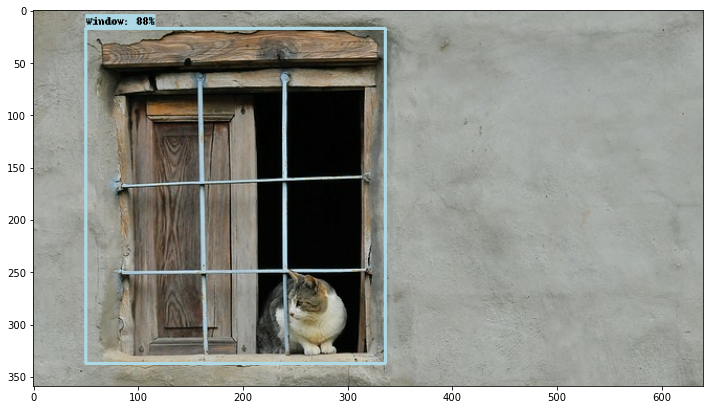

In [29]:
# MobileNet V2
run_detector(detector_1, image_set[5])

Execution time: 0.12 s


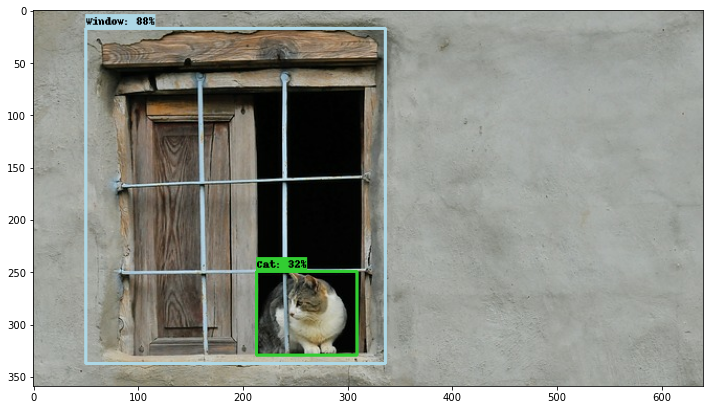

In [30]:
# MobileNet V2
# It was weak result of this model with min_score=.6 
# so let's decrease min_score
min_score = .3
run_detector(detector_1, image_set[5])

<hr>
<hr>

Just for fun :)

#### Style Transfer __[source](https://www.tensorflow.org/lite/models/style_transfer/overview)__

The **Artistic Style Transfer** model consists of two submodels:

1. **Style Prediciton Model**: A `MobilenetV2`-based neural network that takes an input style image to a 100-dimension style bottleneck vector.
2. **Style Transform Model**: A neural network that takes apply a style bottleneck vector to a content image and creates a stylized image.

In [31]:
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 
                                             'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 
                                               'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

#### Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].

* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.

* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

In [32]:
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    
    return img

def preprocess_image(image, target_dim):
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image

In [33]:
content_image = load_img('style_transfer/tall-ship.jpg')
style_image = load_img('style_transfer/zvezdnaya-noch-van-gog.jpg')

preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


#### Visualize the inputs

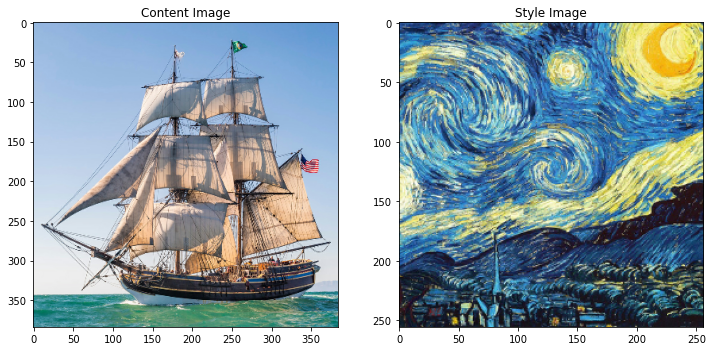

In [34]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')
pass;

In [35]:
# Style prediction
def run_style_predict(preprocessed_style_image):
    interpreter = tf.lite.Interpreter(model_path=style_predict_path)

    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

    interpreter.invoke()
    style_bottleneck = interpreter.tensor(
        interpreter.get_output_details()[0]["index"]
        )()

    return style_bottleneck

In [36]:
# Style transform
def run_style_transform(style_bottleneck, preprocessed_content_image):
    interpreter = tf.lite.Interpreter(model_path=style_transform_path)

    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()

    interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
    interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
    interpreter.invoke()

    stylized_image = interpreter.tensor(
        interpreter.get_output_details()[0]["index"]
        )()

    return stylized_image

Define content blending ratio between [0..1]:

* 0.0: 0% style extracts from content image.
* 1.0: 100% style extracted from content image.

In [ ]:
content_blending_ratio = .6

In [37]:
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256))

style_bottleneck = run_style_predict(preprocessed_style_image)
print(style_bottleneck.shape)

(1, 1, 1, 100)


In [38]:
style_bottleneck_blended = (content_blending_ratio * style_bottleneck_content \
                            + (1 - content_blending_ratio) * style_bottleneck)

In [39]:
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

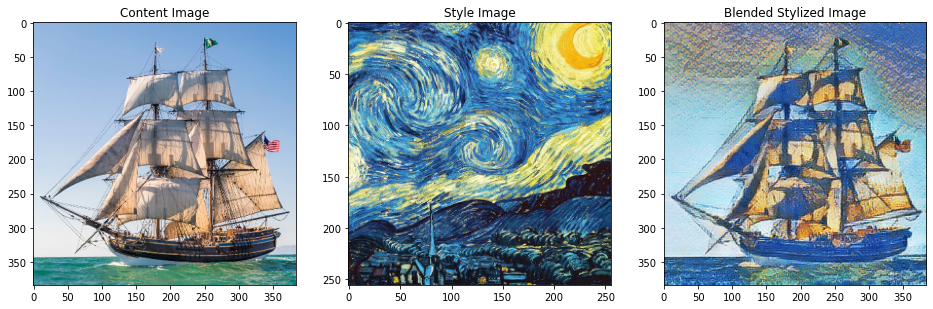

In [49]:
mpl.rcParams['figure.figsize'] = (16,18)

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_image, 'Style Image')

plt.subplot(1, 3, 3)
imshow(stylized_image_blended, 'Blended Stylized Image')
pass;